# Audio model initial evaluation
Se evalúa un modelo TensorFlow de sonido entrenado.
## Imports

In [1]:
from tensorflow.keras.models import load_model
from joblib import load
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

from audio_model_evaluation import get_dataset

## Parámetros

In [1]:
project_dir = "/home/daniel/PycharmProjects/tfg-tinyml"
saved_models_dir = f"{project_dir}/saved models/audio"
label_index_dir = f"{saved_models_dir}/label index mappings"
# model_name = f"MicroAudioDataModel"
# model_name = f"ExtAudioDataModel"
model_name = f"ExtAudioDataModelPrun"
model_dir = f"{saved_models_dir}/tensorflow/{model_name}"
test_dir = f"{project_dir}/samples/external/audio/test"
# test_dir = f"{project_dir}/samples/external/audio/test"
# test_dir = f"{project_dir}/samples/microcontroller/audio/all"

## Carga del modelo
Cargamos un modelo y mostramos un resumen de su estructura.

In [3]:
model = load_model(model_dir)
model.summary()

class_names = load(f"{label_index_dir}/{model_name}.joblib")
class_indexes = {}
for index, name in enumerate(class_names):
    class_indexes[name] = index

Model: "ExtAudioDataModelPrun"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing (Resizing)          (None, 32, 32, 1)         0         
_________________________________________________________________
normalization (Normalization (None, 32, 32, 1)         3         
_________________________________________________________________
prune_low_magnitude_conv2d ( (None, 13, 12, 8)         1290      
_________________________________________________________________
prune_low_magnitude_max_pool (None, 6, 6, 8)           1         
_________________________________________________________________
dropout (Dropout)            (None, 6, 6, 8)           0         
_________________________________________________________________
prune_low_magnitude_flatten  (None, 288)               1         
_________________________________________________________________
prune_low_magnitude_dense (P (None, 4)       

## Carga de datos de test
Cargamos los datos de test sobre los que se realizará inferencias.

In [4]:
test_dataset = get_dataset(test_dir)

test_audios = []
test_labels = []
for audio, label in test_dataset:
    test_audios.append(audio.numpy())
    test_labels.append(label.numpy())
test_audios = np.array(test_audios)
test_labels = np.array(test_labels)

Using 3230 samples.
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


## Inferencia
Se realiza inferencia sobre los archivos de la carpeta test y se muestran los resultados.

In [5]:
predictions = np.argmax(model.predict(test_audios), axis=1)

## Visualización de métricas

Se muestran datos acerca del comportamiento general del modelo al evaluar las muestras.

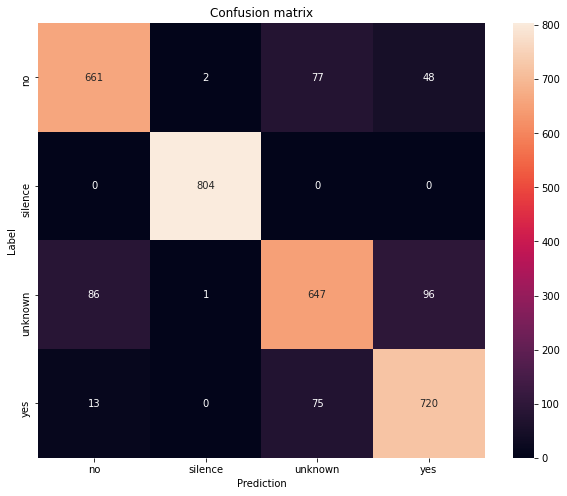

              precision    recall  f1-score   support

          no       0.87      0.84      0.85       788
     silence       1.00      1.00      1.00       804
     unknown       0.81      0.78      0.79       830
         yes       0.83      0.89      0.86       808

    accuracy                           0.88      3230
   macro avg       0.88      0.88      0.88      3230
weighted avg       0.88      0.88      0.88      3230



In [6]:
confusion_mtx = confusion_matrix(test_labels, predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=class_names, yticklabels=class_names, annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.title("Confusion matrix")
plt.show()
print(classification_report(test_labels, predictions, target_names=class_names))